In [1]:
import torch
import scanpy as sc

from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
os.chdir("../")

from sklearn.decomposition import PCA
from scvi.model import SCVI
from scripts import constants
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
dataset = "norman_2019"
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    )
)

target_adata = adata[adata.obs["gene_program"] != "Ctrl"]

In [3]:
from tqdm import tqdm

seeds = constants.DEFAULT_SEEDS

contrastiveVI_salient_embeddings = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            "norman_2019",
            "contrastiveVI",
            "latent_10",
            str(seed),
            "latent_representations.npy"
        )
    ) for seed in tqdm(seeds)]

cplvm_salient_embeddings = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            "norman_2019",
            "CPLVM",
            "latent_10",
            str(seed),
            "latent_representations.npy"
        )
    ) for seed in tqdm(seeds)]

cglvm_salient_embeddings = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            "norman_2019",
            "CGLVM",
            "latent_10",
            str(seed),
            "latent_representations.npy"
        )
    ) for seed in tqdm(seeds)]

scVI_embeddings = [
    np.load(
        os.path.join(
            constants.DEFAULT_RESULTS_PATH,
            "norman_2019",
            "scVI",
            "latent_10",
            str(seed),
            "latent_representations.npy"
        )
    ) for seed in tqdm(seeds)]

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


In [4]:
from anndata import AnnData

adata_salient = AnnData(X = contrastiveVI_salient_embeddings[2], obs=target_adata.obs)
adata_scvi = AnnData(X = scVI_embeddings[2], obs=target_adata.obs)

In [5]:
sc.pp.neighbors(target_adata)
sc.tl.umap(target_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [6]:
sc.pp.neighbors(adata_scvi)
sc.tl.umap(adata_scvi)

In [7]:
sc.pp.neighbors(adata_salient)
sc.tl.umap(adata_salient)

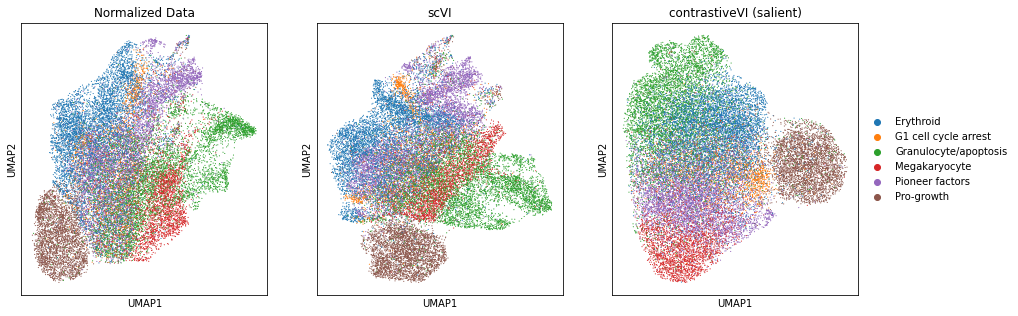

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sc.pl.umap(target_adata, color='gene_program', title='Normalized Data', ax=ax1, show=False, legend_loc=None)
sc.pl.umap(adata_scvi, color='gene_program', title='scVI', ax=ax2, show=False, legend_loc=None)
sc.pl.umap(adata_salient, color='gene_program', title='contrastiveVI (salient)', ax=ax3)

In [9]:
label = 'Granulocyte/apoptosis'
adata_label = adata_salient[adata_salient.obs['gene_program'] == label]

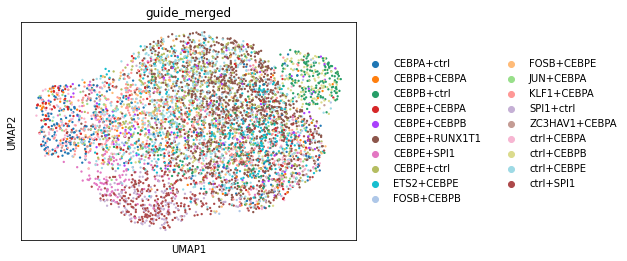

In [10]:
sc.pp.neighbors(adata_label)
sc.tl.umap(adata_label)
sc.pl.umap(adata_label, color='guide_merged')

In [11]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

In [12]:
metrics = {}

metrics["ARI"] = {}
metrics["AMI"] = {}
metrics["Silhouette"] = {}

metrics["ARI"]["contrastiveVI"] = [
    adjusted_rand_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(contrastiveVI_salient_embeddings)]

metrics["ARI"]["scVI"] = [
    adjusted_rand_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(scVI_embeddings)]

metrics["ARI"]["CPLVM"] = [
    adjusted_rand_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cplvm_salient_embeddings)]

metrics["ARI"]["CGLVM"] = [
    adjusted_rand_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cglvm_salient_embeddings)]

metrics["AMI"]["contrastiveVI"] = [
    adjusted_mutual_info_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(contrastiveVI_salient_embeddings)]

metrics["AMI"]["scVI"] = [
    adjusted_mutual_info_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(scVI_embeddings)]

metrics["AMI"]["CPLVM"] = [
    adjusted_mutual_info_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cplvm_salient_embeddings)]

metrics["AMI"]["CGLVM"] = [
    adjusted_mutual_info_score(
        KMeans(n_clusters=6).fit(x).labels_,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cglvm_salient_embeddings)]

metrics["Silhouette"]["contrastiveVI"] = [
    silhouette_score(
        x,
        adata_salient.obs['gene_program']
    ) for x in tqdm(contrastiveVI_salient_embeddings)]

metrics["Silhouette"]["scVI"] = [
    silhouette_score(
        x,
        adata_salient.obs['gene_program']
    ) for x in tqdm(scVI_embeddings)]

metrics["Silhouette"]["CPLVM"] = [
    silhouette_score(
        x,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cplvm_salient_embeddings)]

metrics["Silhouette"]["CGLVM"] = [
    silhouette_score(
        x,
        adata_salient.obs['gene_program']
    ) for x in tqdm(cglvm_salient_embeddings)]

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.42s/it]


In [13]:
from scipy.stats import sem


np.mean(metrics["ARI"]["contrastiveVI"])

0.2892536557605983

[Text(0.15, 0, 'scVI'),
 Text(1.15, 0, 'CPLVM\n(Salient)'),
 Text(2.15, 0, 'CGLVM\n(Salient)'),
 Text(3.15, 0, 'contrastiveVI\n(Salient)')]

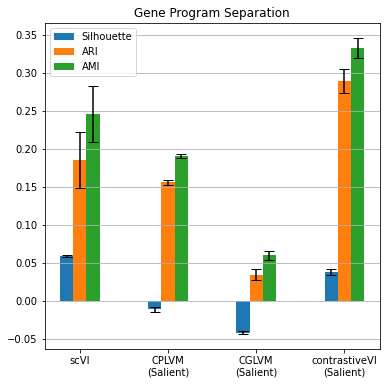

In [14]:
from scipy.stats import sem

ordered_methods = ["scVI", "CPLVM", "CGLVM", "contrastiveVI"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
width = 0.15  # Bar width
x = np.arange(len(ordered_methods))

ax.bar(
    x,
    [np.mean(metrics["Silhouette"][x]) for x in ordered_methods],
    width,
    yerr = [sem(metrics["Silhouette"][x]) for x in ordered_methods],
    capsize=5,
    label="Silhouette",
)

ax.bar(
    x+width,
    [np.mean(metrics["ARI"][x]) for x in ordered_methods],
    width,
    yerr = [sem(metrics["ARI"][x]) for x in ordered_methods],
    capsize=5,
    label="ARI",
)

ax.bar(
    x+2*width,
    [np.mean(metrics["AMI"][x]) for x in ordered_methods],
    width,
    yerr = [sem(metrics["AMI"][x]) for x in ordered_methods],
    capsize=5,
    label="AMI",
)

ax.grid(axis="y")
ax.set_title("Gene Program Separation")
ax.legend()


xticklabels = []
for method in ordered_methods:
    if method == "scVI":
        xticklabels.append(method)
    else:
        xticklabels.append(f"{method}\n(Salient)")
ax.set_xticks(x + width)
ax.set_xticklabels(xticklabels)